In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
words = open('../names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [ ]:
n_embd = 32 # the dimensionality of the character embedding vectors
n_hidden = 200
n_iters = 20_000
bs = 256

In [ ]:
class LinearNN(nn.Module):
    def __init__(self):
        super(LinearNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, n_embd)
        self.fc1 = nn.Linear(n_embd * block_size, n_hidden)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.bn2 = nn.BatchNorm1d(n_hidden)
        self.fc3 = nn.Linear(n_hidden, vocab_size)

    def forward(self, x):
        x = self.emb(x).view(-1, n_embd * block_size)
        x = self.bn1(torch.tanh(self.fc1(x)))
        x = self.bn2(torch.tanh(self.fc2(x)))
        x = self.fc3(x)
        return x
model = LinearNN()
model

LinearNN(
  (emb): Embedding(27, 32)
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=200, out_features=27, bias=True)
)

In [ ]:
from functools import partial

class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self)) 
    
    def remove(self): 
        self.hook.remove()
    
    def __del__(self): 
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): 
        hook.stats = ([], [], [])
    means, stds, hists= hook.stats 
    means.append(outp.data.mean())
    stds.append(outp.data.std())
    hists.append(outp.data.cpu().histc(40,0,10))

# Register the hook
layers_to_hook = ['fc1', 'fc2', 'fc3']

# Create hooks for specified layers
hooks = []
for name, module in model.named_children():
    if name in layers_to_hook:
        hook = Hook(module, append_stats)
        hooks.append(hook)

In [ ]:
lossi = []
for i in range(n_iters):
  ix = torch.randint(0, Xtr.shape[0], (bs,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch
    
  pred = model(Xb)

  loss = F.cross_entropy(pred, Yb)

  # backward pass
  model.zero_grad()
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  with torch.no_grad():
      for p in model.parameters():
        p.data -= lr * p.grad

  if i % 1000 == 0:
    print(f"{i} -> {loss.item():.4f}")

  lossi.append(loss.log10().item())
  #if i >= 1000:
  #  break 

0 -> 3.5486
1000 -> 2.1238
2000 -> 2.1420
3000 -> 2.0688
4000 -> 2.0437
5000 -> 2.0511
6000 -> 2.0461
7000 -> 2.0521
8000 -> 1.9058
9000 -> 1.7948
10000 -> 1.8881
11000 -> 1.9402
12000 -> 1.9776
13000 -> 1.8021
14000 -> 1.7695
15000 -> 1.8976
16000 -> 1.7476
17000 -> 1.7897
18000 -> 1.8033
19000 -> 1.7033


In [ ]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([20, 1000])

[<matplotlib.lines.Line2D>]

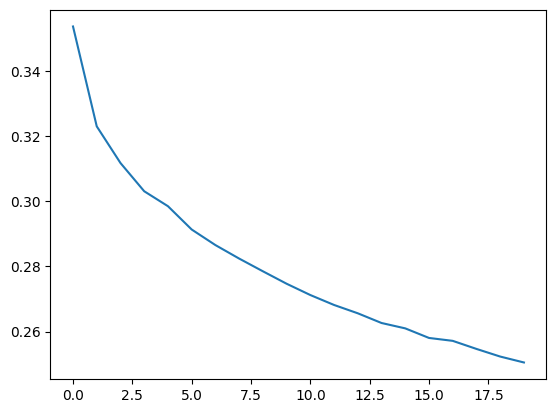

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
@torch.no_grad
def split_loss(split):
        x,y = {
            'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte),
        }[split]
        
        model.eval()
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 1.7644972801208496
val 2.0529983043670654
test 2.056380271911621


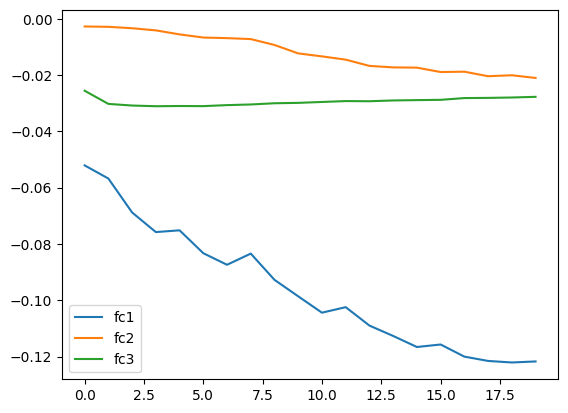

In [ ]:
legends = []
for i, h in enumerate(hooks):
    stats = torch.tensor(h.stats[0][3:]).view(-1, 1000).mean(1)
    plt.plot(stats)
    legends.append(f"{layers_to_hook[i]}")
    #h.remove()
plt.legend(legends);

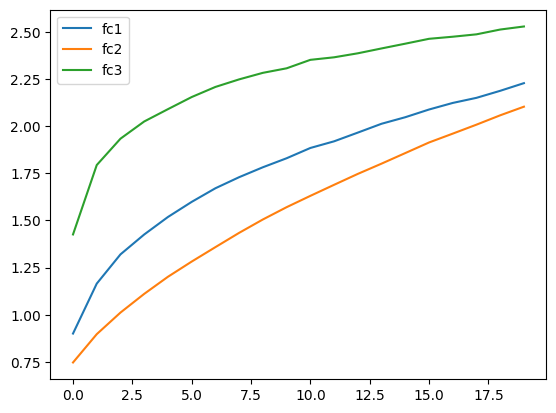

In [ ]:
legends = []
for i, h in enumerate(hooks):
    stats = torch.tensor(h.stats[1][3:]).view(-1, 1000).mean(1)
    plt.plot(stats)
    legends.append(f"{layers_to_hook[i]}")
    #h.remove()
plt.legend(legends);

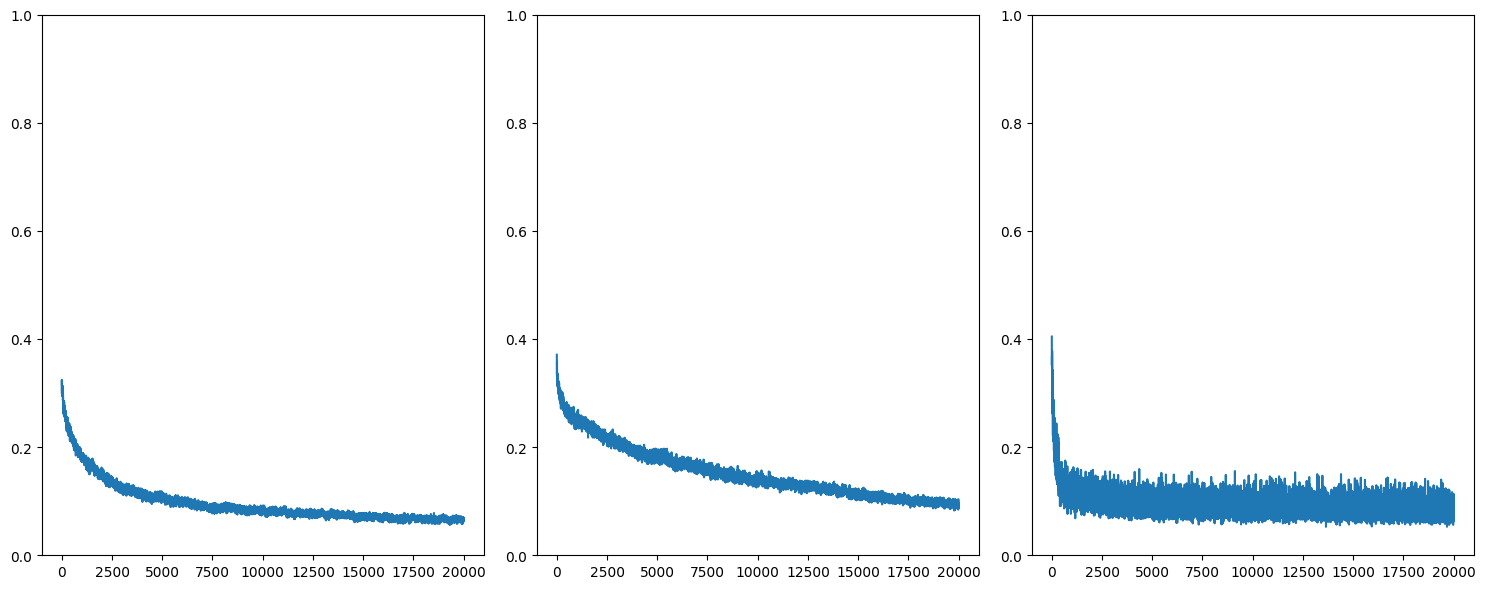

In [ ]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:1].sum(0)/h1.sum(0)
     

fig,axes = plt.subplots(1,3, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()